# <span style="color:green"><center>Diplomado en Big Data</center></span>

# <span style="color:red"><center> Dask DataFrames: Grandes dataframes paralelizados<center></span>

<img src="../images/dask_horizontal.svg" align="right" width="30%">


##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Contenido</span>


* [Introducción](#Introducción)
* [Cuándo usar dask.dataframe](#Cuándo-usar-dask.dataframe)
* [Creación de datos](#Creación-de-datos)
* [Configuración](#Configuración)
* [Computación con dask.dataframe](#Computación-con-dask.dataframe)
* [Compartir resultados intermedios](#Compartir-resultados-intermedios)
* [¿Cómo se compara esto con los pandas?](#¿Cómo-se-compara-esto-con-los-pandas?)
* [Modelo de datos Dask DataFrame](#Modelo-de-datos-Dask-DataFrame)
* [Conversión de CRSDepTime en una marca de tiempo](#Conversión-de-CRSDepTime-en-una-marca-de-tiempo)
* [Limitaciones](#Limitaciones)
* [Aprender más](#Aprender-más)


## <span style="color:blue">Fuente</span>

Esta es una traducción libre del tutorial disponible en [dask-tutorial](https://github.com/dask/dask-tutorial).

## <span style="color:blue">Introducción</span>

Terminamos el capítulo 1 de este tutorial mediante la construcción de un cálculo de datos de datos paralelos en un directorio de archivos CSV usando `Dask.Delayed`. 

En esta sección, usamos `Dask.DataFrame` para construir automáticamente cálculos similiares, para el caso común de cálculos tabulares. 


Los dataframe  de Dask se ven y se sienten como los dataframe de Pandas, pero se ejecutan en la misma infraestructura que potencia `Dask.Delayed`.

En este cuaderno, usamos los mismos datos de la aerolínea que antes, pero ahora en lugar de escribir los bucles, le permitimos a `Dask.DataFrame` que construya los cálculos para nosotros. 

La función `dask.dataframe.read_csv` puede tomar una globalización usando el patrón `data/nycflights/*.csv`  y construir cálculos paralelos en todos nuestros datos a la vez.

## <span style="color:blue">Cuándo usar dask.dataframe</span>

Pandas es ideal para conjuntos de datos tabulares que encajan en la memoria. Dask se vuelve útil cuando el conjunto de datos que desea analizar es más grande que la RAM de su máquina. El conjunto de datos de demostración con el que estamos trabajando es solo de 200 MB, para que pueda descargarlo en un tiempo razonable, pero `Dask.DataFrame` se escalará a los conjuntos de datos mucho más grandes que la memoria.

<img src="../images/pandas_logo.png" align="right" width="28%">

El módulo `Dask.DataFrame` implementa un objeto bloqueado en paralelo `DataFrame` que imita un gran subconjunto de la API de Pandas `DataFrame`. Un Dask `DataFrame` está compuesto por muchos dataframes de Pandas en memoria que se separan a lo largo del índice. Una operación en un marcador de datos de Dask "desencadena muchas operaciones de Pandas en el dataframe de Pandas  de una forma en que es consciente de las restricciones de paralelismo y memoria potenciales.

**Documentación relacionada**
* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

**principales alertas**

1. La estructura de datos de Dask debe ser familiar para los usuarios de Pandas
2. La partición de los dataframe es importante para la ejecución eficiente.

## <span style="color:blue">Crear los datos</span>

In [ ]:
#%run prep.py -d flights

In [ ]:
python prep.py -d random

## <span style="color:blue">Configuración</span>

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

Creamos datos artificiales.

In [6]:
from prep import accounts_csvs
accounts_csvs()

import os
import dask

In [7]:
filename = os.path.join('../data', 'accounts.*.csv')
filename

'../data/accounts.*.csv'

El objeto *filename* incluye un patrón global `*`, por lo que todos los archivos en la ruta que coincida con ese patrón se leerán en el mismo Dask DataFrame.

In [8]:
import dask.dataframe as dd
df = dd.read_csv(filename)
df.head()

,id,names,amount
0,66,Ursula,-839
1,272,Victor,422
2,275,Hannah,406
3,267,Victor,888
4,318,Sarah,795


In [9]:
# load and count number of rows
len(df)

3000000

¿Que pasó aquí?

- Dask buscó la ruta de entrada y descubrió que hay tres archivos coincidentes
- se creó de forma inteligente un conjunto de trabajos para cada fragmento - uno por archivo CSV original en este caso
- cada archivo se cargó en un dataframe de pandas, se le ha aplicado `len()`
- los subtotales se combinaron para obtener el gran total final.

### Datos reales

Intentemos esto con un extracto de vuelos en los EE. UU. A lo largo de varios años. Estos datos son específicos para vuelos de los tres aeropuertos en el área de la ciudad de Nueva York (New York).

In [11]:
df = dd.read_csv(os.path.join('../data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

Observe que la representación del objeto ddataframe  no contiene datos: Dask acaba de hacer lo suficiente para leer el inicio del primer archivo e inferir los nombres de columna y los tipos de datos.

In [12]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Podemos ver el inicio y el final de los datos.

In [15]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [17]:
df.tail()  # this fails

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

### ¿Qué acaba de suceder?

A diferencia de `pandas.read_csv`, que lee todo el archivo antes de inferir los tipos de datos,` dask.dataframe.read_csv` solo lee una muestra desde el principio del archivo (o el primer archivo si se usa un glob). Estos tipos de datos inferidos se aplican luego al leer todas las particiones.

En este caso, los tipos de datos inferidos en la muestra son incorrectos. Las primeras `n` filas no tienen ningún valor para` CRSElapsedTime` (que pandas infiere como un `float`), y luego resultan ser cadenas (` object` dtype). Tenga en cuenta que Dask muestra un mensaje de error informativo sobre la falta de coincidencia. Cuando esto sucede, tiene algunas opciones:

- Especifique dtypes directamente usando la palabra clave `dtype`. Esta es la solución recomendada, ya que es la menos propensa a errores (mejor ser explícita que implícita) y también la más eficaz.
- Aumentar el tamaño de la palabra clave `sample` (en bytes)
- Utilice `asume_missing` para hacer que` dask` asuma que las columnas inferidas como `int` (que no permiten valores perdidos) son en realidad flotantes (que sí permiten valores perdidos). En nuestro caso particular, esto no se aplica.

En nuestro caso, usaremos la primera opción y especificaremos directamente los `dtypes` de las columnas ofensivas.

In [20]:
df = dd.read_csv(os.path.join('../data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [21]:
df.tail()  # now works

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


## <span style="color:blue">Computación con `dask.dataframe`</span>

Calculamos el máximo de la columna `DepDelay`. Con solo pandas, recorreríamos cada archivo para encontrar los máximos individuales, luego encontraríamos el máximo final sobre todos los máximos individuales

```python
maxes = []
for fn in filenames:
    df = pd.read_csv(fn)
    maxes.append(df.DepDelay.max())
    
final_max = max(maxes)
```

Podríamos envolver ese `pd.read_csv` con` dask.delayed` para que se ejecute en paralelo. Independientemente, todavía tenemos que pensar en los bucles, los resultados intermedios (uno por archivo) y la reducción final ("max" de los máximos intermedios). Esto es solo ruido alrededor de la tarea real, que los pandas resuelven con

```python
df = pd.read_csv(filename, dtype=dtype)
df.DepDelay.max()
```

`dask.dataframe` nos permite escribir código similar a un pandas, que opera en conjuntos de datos más grandes que la memoria en paralelo.

In [22]:
%time df.DepDelay.max().compute()

CPU times: user 627 ms, sys: 140 ms, total: 767 ms
Wall time: 6.26 s


1435.0

Esto escribe el cálculo retrasado por nosotros y luego lo ejecuta.

Algunas cosas a tener en cuenta:

1. Como con `dask.delayed`, necesitamos llamar a` .compute () `cuando hayamos terminado. Hasta este punto todo es flojo.
2. Dask eliminará los resultados intermedios (como el marco de datos de pandas completo para cada archivo) lo antes posible.
     - Esto nos permite manejar conjuntos de datos que son más grandes que la memoria.
     - Esto significa que los cálculos repetidos tendrán que cargar todos los datos cada vez (ejecute el código anterior nuevamente, ¿es más rápido o más lento de lo que esperaría?)
    
Al igual que con los objetos `Retrasados`, puede ver el gráfico de tareas subyacente utilizando el método` .visualize`:

In [ ]:
# notice the parallelism
df.DepDelay.max().visualize()

## Ejercicios

En esta sección hacemos algunos cálculos `dask.dataframe`. Si te sientes cómodo con los pandas, entonces estos deberían ser familiares. Tendrá que pensar en cuándo llamar a `compute`.

###  ¿Cuántas filas hay en nuestro conjunto de datos?

Si no está familiarizado con los pandas, ¿cómo comprobaría cuántos registros hay en una lista de tuplas?

In [ ]:
# Your code here

In [23]:
len(df)

2611892

### En total, ¿cuántos vuelos no cancelados se tomaron?

Con pandas, usarías [boolean indexing](https://pandas.pydata.org/pandas-docs/stable/indexing.html#boolean-indexing).

In [ ]:
# Your code here

In [24]:
len(df[~df.Cancelled])

2540961

### En total, ¿cuántos vuelos no cancelados se tomaron de cada aeropuerto?

*Pista*: utilizar [`df.groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

In [ ]:
# Your code here

In [25]:
df[~df.Cancelled].groupby('Origin').Origin.count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

### ¿Cuál fue la demora promedio de salida de cada aeropuerto?

Tenga en cuenta que este es el mismo cálculo que hizo en el cuaderno anterior (¿este enfoque es más rápido o más lento?)

In [ ]:
# Your code here

In [26]:
df.groupby("Origin").DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### ¿Qué día de la semana tiene el peor retraso promedio de salida?

In [ ]:
# Your code here

In [ ]:
df.groupby("DayOfWeek").DepDelay.mean().compute()

## <span style="color:blue">Compartir resultados intermedios</span>

Al calcular todo lo anterior, a veces hicimos la misma operación más de una vez. Para la mayoría de las operaciones, `dask.dataframe` aplica un hash a los argumentos, lo que permite que los cálculos duplicados se compartan y solo se computen una vez.

Por ejemplo, calculemos la desviación media y estándar de la demora en la salida de todos los vuelos no cancelados. Dado que las operaciones de dask son perezosas, esos valores aún no son los resultados finales. Son solo la receta necesaria para obtener el resultado.

Si los calculamos con dos llamadas a calcular, no se comparten los cálculos intermedios.

In [27]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

In [28]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 1.31 s, sys: 226 ms, total: 1.54 s
Wall time: 10.7 s


But let's try by passing both to a single `compute` call.

In [29]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 756 ms, sys: 104 ms, total: 861 ms
Wall time: 5.71 s


Usar `dask.compute` lleva aproximadamente la mitad del tiempo. Esto se debe a que los grafos de tareas para ambos resultados se combinan al llamar a `dask.compute`, lo que permite que las operaciones compartidas solo se realicen una vez en lugar de dos. En particular, usar `dask.compute` solo hace lo siguiente una vez:

- las llamadas a `read_csv`
- el filtro (`df [~ df.Cancelled]`)
- algunas de las reducciones necesarias (`sum`,` count`)

Para ver cómo se ven los gráficos de tareas fusionados entre varios resultados (y qué se comparte), puede usar la función `dask.visualize` (es posible que deseemos usar` filename = 'graph.pdf'` para guardar el gráfico en el disco así que podemos acercar más fácilmente):

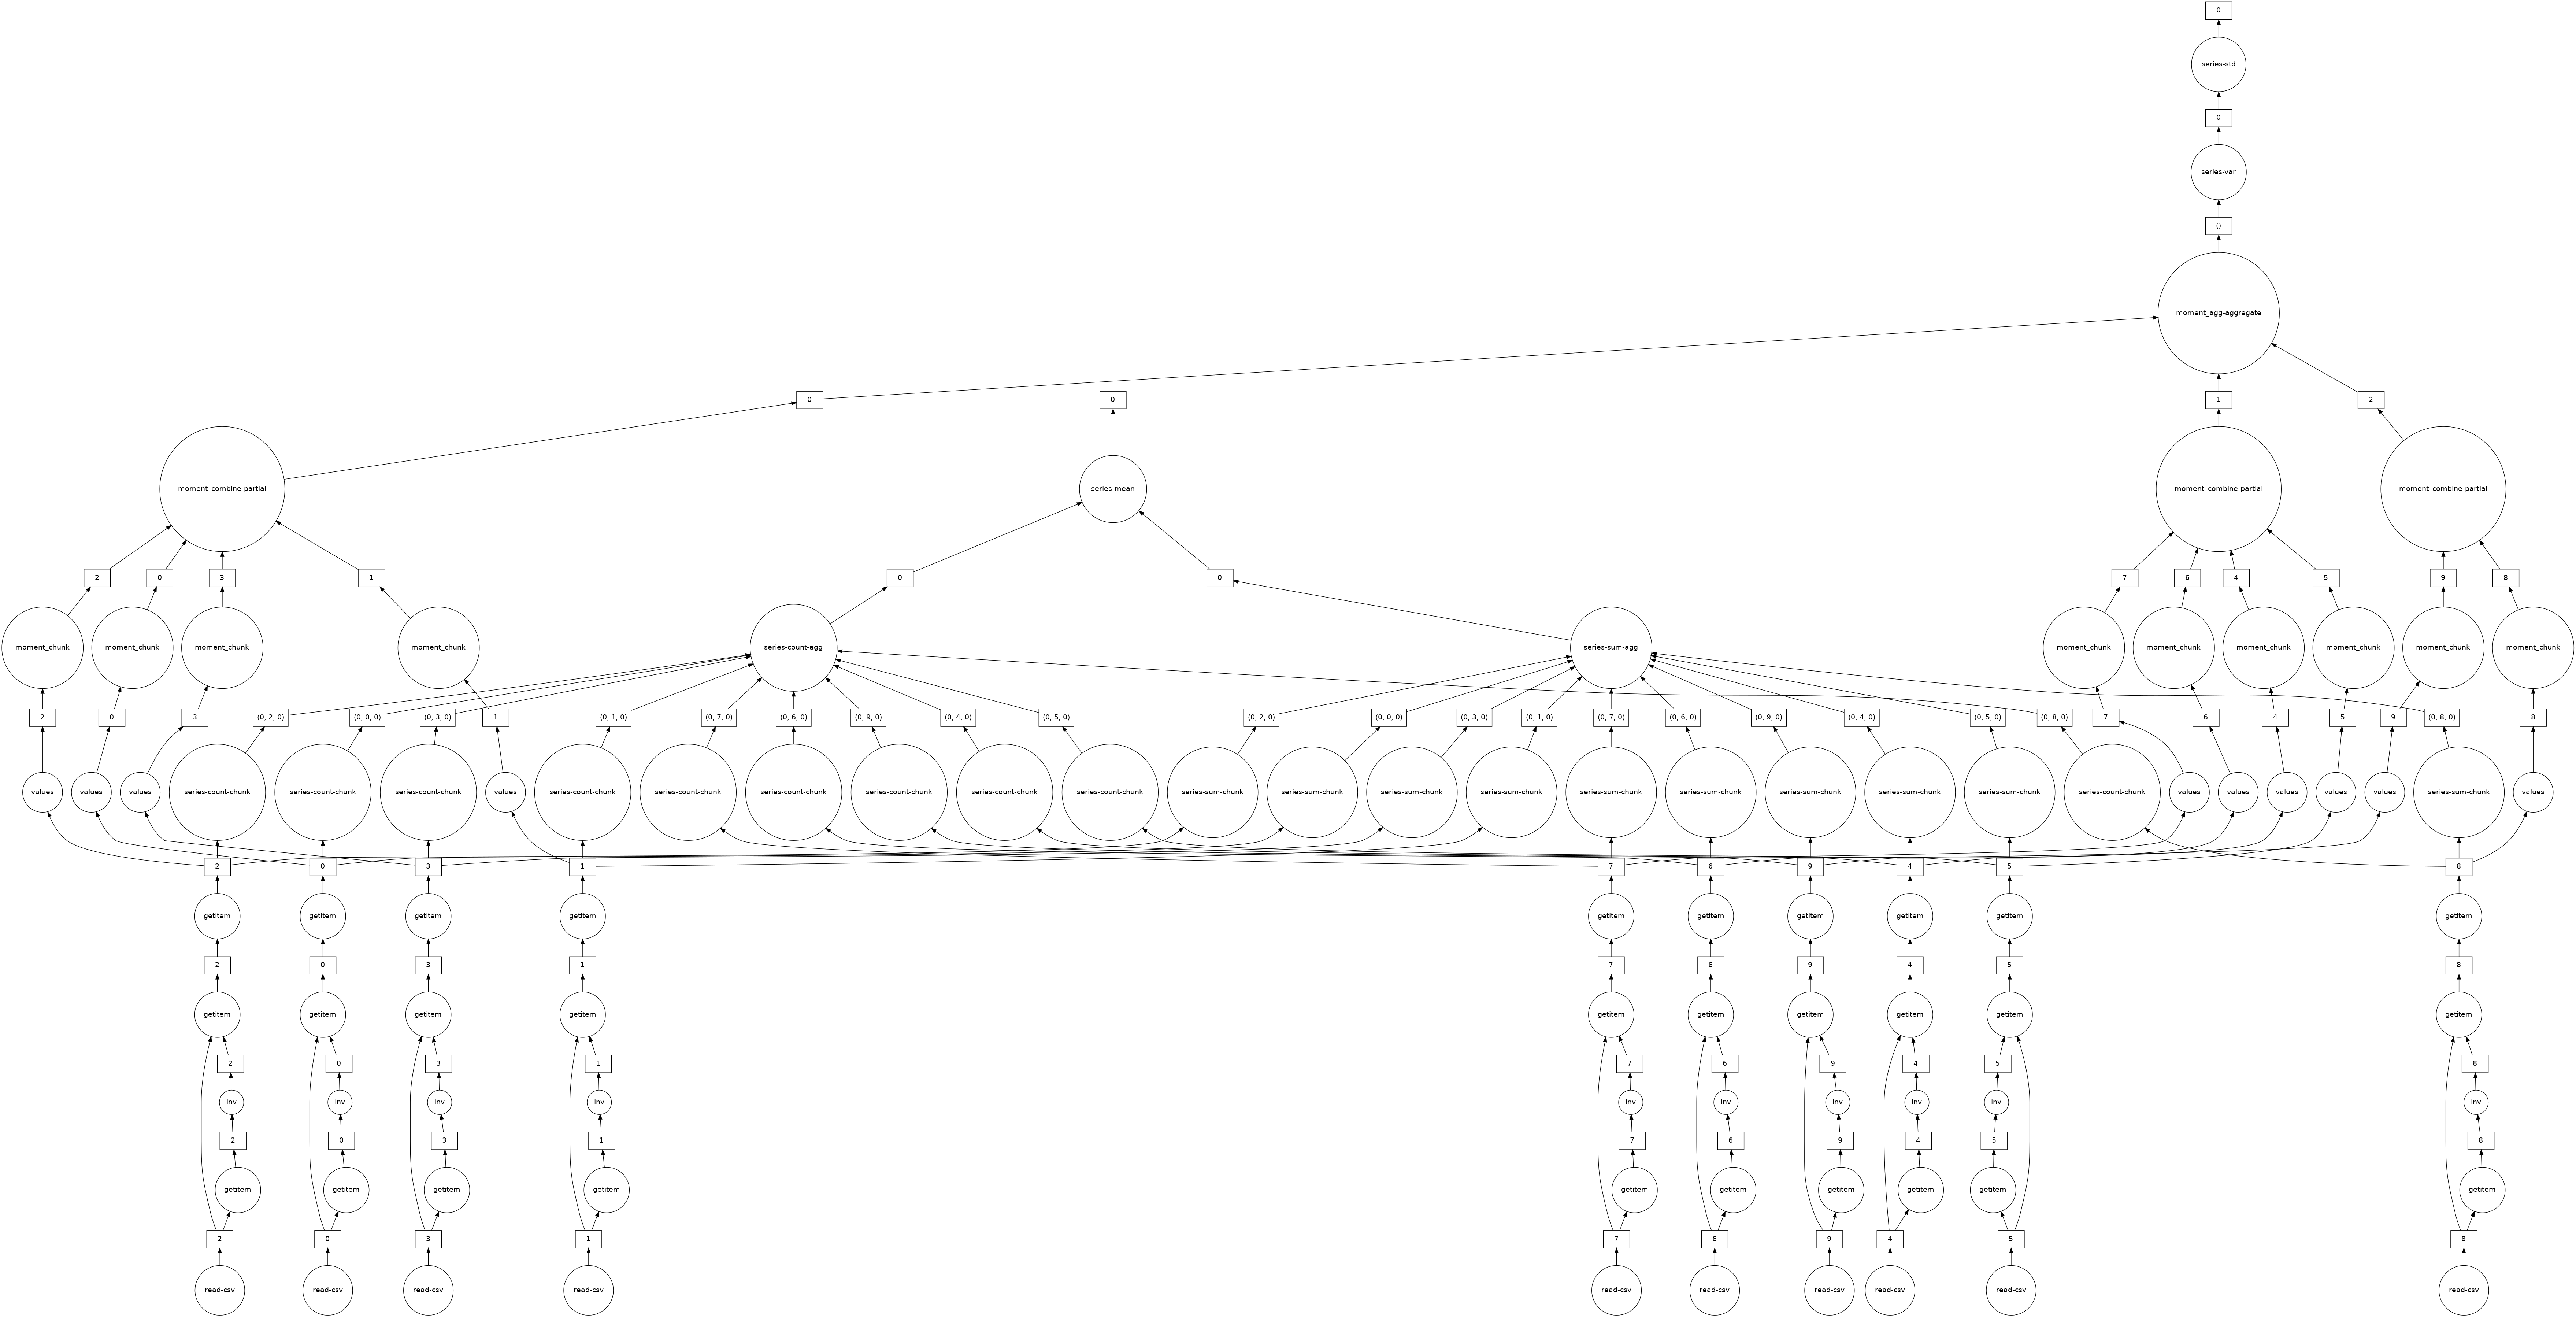

In [30]:
dask.visualize(mean_delay, std_delay)

## <span style="color:blue">¿Cómo se compara esto con los pandas?</span>

Pandas es más maduro  con todas las funciones que `dask.dataframe`. Si sus datos caben en la memoria, entonces debería usar Pandas. El módulo `dask.dataframe` le brinda una experiencia limitada de` pandas` cuando opera en conjuntos de datos que no caben cómodamente en la memoria.

Durante este tutorial, proporcionamos un pequeño conjunto de datos que consta de algunos archivos CSV. Este conjunto de datos tiene 45 MB en disco y se expande a aproximadamente 400 MB de memoria. Este conjunto de datos es lo suficientemente pequeño como para que normalmente use Pandas.

Hemos elegido este tamaño para que los ejercicios terminen rápidamente. Dask.dataframe solo se vuelve significativo para problemas significativamente más grandes que este, cuando Pandas rompe con el temido

    MemoryError: ...
    
Además, el planificador distribuido permite que se ejecuten las mismas expresiones de tramas de datos en un clúster. Para habilitar el procesamiento masivo de "big data", se pueden ejecutar funciones de ingestión de datos como `read_csv`, donde los datos se almacenan en un almacenamiento accesible para todos los nodos trabajadores (por ejemplo, el S3 de Amazon), y porque la mayoría de las operaciones comienzan seleccionando solo algunas columnas , transformando y filtrando los datos, solo es necesario comunicar cantidades relativamente pequeñas de datos entre las máquinas.

Las operaciones Dask.dataframe utilizan operaciones `pandas` internamente. Por lo general, funcionan aproximadamente a la misma velocidad, excepto en los dos casos siguientes:

1. Dask introduce un poco de sobrecarga, alrededor de 1 ms por tarea. Esto suele ser insignificante.
2. Cuando Pandas libera el GIL, `dask.dataframe` puede llamar a varias operaciones pandas en paralelo dentro de un proceso, aumentando la velocidad de forma algo proporcional al número de núcleos. Para las operaciones que no liberan el GIL, se necesitarían múltiples procesos para obtener la misma aceleración.

## <span style="color:blue">Modelo de datos Dask DataFrame</span>

En su mayor parte, un Dask DataFrame se siente como un pandas DataFrame.
Hasta ahora, la mayor diferencia que hemos visto es que las operaciones de Dask son perezosas; construyen un gráfico de tareas en lugar de ejecutarlas de inmediato (más detalles en [Schedulers](05_distributed.ipynb)).
Esto permite que Dask realice operaciones en paralelo y fuera del núcleo.

En [Dask Arrays](03_array.ipynb), vimos que un `dask.array` estaba compuesto por muchas matrices NumPy, fragmentadas a lo largo de una o más dimensiones. Es similar para `dask.dataframe`: un Dask DataFrame se compone de muchos pandas DataFrames. Para `dask.dataframe`, la fragmentación ocurre solo a lo largo del índice.

<img src="http://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width="30%">

Llamamos a cada fragmento una * partición *, y los límites superior / inferior son * divisiones *.
Dask * puede * almacenar información sobre las divisiones. Por ahora, las particiones surgen cuando escribe funciones personalizadas para aplicarlas a Dask DataFrames

## <span style="color:blue">Conversión de CRSDepTime en una marca de tiempo</span>

Este conjunto de datos almacena marcas de tiempo como "HHMM", que se leen como números enteros en "read_csv":

In [31]:
crs_dep_time = df.CRSDepTime.head(10)
crs_dep_time

0    1540
1    1540
2    1540
3    1540
4    1540
5    1540
6    1540
7    1540
8    1540
9    1540
Name: CRSDepTime, dtype: int64

Para convertirlos en marcas de tiempo de la hora de salida programada, necesitamos convertir estos números enteros en objetos `pd.Timedelta`, y luego combinarlos con la columna` Date`.

En pandas haríamos esto usando la función `pd.to_timedelta`, y un poco de aritmética:

In [32]:
import pandas as pd

# Get the first 10 dates to complement our `crs_dep_time`
date = df.Date.head(10)

# Get hours as an integer, convert to a timedelta
hours = crs_dep_time // 100
hours_timedelta = pd.to_timedelta(hours, unit='h')

# Get minutes as an integer, convert to a timedelta
minutes = crs_dep_time % 100
minutes_timedelta = pd.to_timedelta(minutes, unit='m')

# Apply the timedeltas to offset the dates by the departure time
departure_timestamp = date + hours_timedelta + minutes_timedelta
departure_timestamp

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
5   1990-01-06 15:40:00
6   1990-01-07 15:40:00
7   1990-01-08 15:40:00
8   1990-01-09 15:40:00
9   1990-01-10 15:40:00
dtype: datetime64[ns]

### Código personalizado y Dask Dataframe

Podríamos cambiar `pd.to_timedelta` por` dd.to_timedelta` y hacer las mismas operaciones en todo el Dask DataFrame. Pero digamos que Dask no había implementado un `dd.to_timedelta` que funciona en Dask DataFrames. ¿Qué harás entonces?

`dask.dataframe` proporciona algunos métodos para facilitar la aplicación de funciones personalizadas a Dask DataFrames:
- [`map_partitions`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_partitions)
- [`map_overlap`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_overlap)
- [`reduction`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.reduction)

Aquí solo discutiremos `map_partitions`, que podemos usar para implementar` to_timedelta` por nuestra cuenta:

In [ ]:
# Look at the docs for `map_partitions`

help(df.CRSDepTime.map_partitions)

La idea básica es aplicar una función que opere en un DataFrame a cada partición.
En este caso, aplicaremos `pd.to_timedelta`.

In [34]:
hours = df.CRSDepTime // 100
# hours_timedelta = pd.to_timedelta(hours, unit='h')
hours_timedelta = hours.map_partitions(pd.to_timedelta, unit='h')

minutes = df.CRSDepTime % 100
# minutes_timedelta = pd.to_timedelta(minutes, unit='m')
minutes_timedelta = minutes.map_partitions(pd.to_timedelta, unit='m')

departure_timestamp = df.Date + hours_timedelta + minutes_timedelta

In [35]:
departure_timestamp

Dask Series Structure:
npartitions=10
    datetime64[ns]
               ...
         ...      
               ...
               ...
dtype: datetime64[ns]
Dask Name: add, 90 tasks

In [36]:
departure_timestamp.head()

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

### Ejercicio: reescribe lo anterior para usar una sola llamada a `map_partitions`

Esto será un poco más eficiente que dos llamadas separadas, ya que reduce la cantidad de tareas en el gráfico.

In [ ]:
def compute_departure_timestamp(df):
    pass  # TODO: implement this

In [ ]:
departure_timestamp = df.map_partitions(compute_departure_timestamp)

departure_timestamp.head()

In [ ]:
def compute_departure_timestamp(df):
    hours = df.CRSDepTime // 100
    hours_timedelta = pd.to_timedelta(hours, unit='h')

    minutes = df.CRSDepTime % 100
    minutes_timedelta = pd.to_timedelta(minutes, unit='m')

    return df.Date + hours_timedelta + minutes_timedelta

departure_timestamp = df.map_partitions(compute_departure_timestamp)
departure_timestamp.head()

## <span style="color:blue">Limitaciones</span>

### ¿Qué no funciona?

Dask.dataframe solo cubre una parte pequeña pero bien utilizada de la API de Pandas.
Esta limitación se debe a dos razones:

1. La API de Pandas es * enorme *
2. Algunas operaciones son realmente difíciles de realizar en paralelo (por ejemplo, ordenar)

Además, algunas operaciones importantes como `` set_index '' funcionan, pero son más lentas
que en Pandas porque incluyen una mezcla sustancial de datos y pueden escribir en el disco.

## <span style="color:blue">Aprender más</span>

* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

In [37]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
